In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
import torch.nn.functional as F

### Encoder-Decoder Model Arch. for Creating Depth Estimation 

Following a standard encoder-decoder architecture, we leverage features extracted using high performing pre-trained networks like Dense Net. 

Using Transfer learning high performing pre-trained networks that are originally designed for image classification as our deep features encoder. Transfer learning-based approach allows for a more modular architecture where future advances in one domain are easily transferred to the depth estimation problem. So there is no need to train the encoder entirely from scratch . 

In [2]:
class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.convA( torch.cat([up_x, concat_with], dim=1)  ) )  )

In [3]:
class Decoder(nn.Module):
    def __init__(self, num_features=1664, decoder_width = 1.0):
        super(Decoder, self).__init__()
        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features, kernel_size=1, stride=1, padding=0)

        self.up1 = UpSample(skip_input=features//1 + 256, output_features=features//2)
        self.up2 = UpSample(skip_input=features//2 + 128,  output_features=features//4)
        self.up3 = UpSample(skip_input=features//4 + 64,  output_features=features//8)
        self.up4 = UpSample(skip_input=features//8 + 64,  output_features=features//16)

        self.conv3 = nn.Conv2d(features//16, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, features):
        x_block0, x_block1, x_block2, x_block3, x_block4 = features[3], features[4], features[6], features[8], features[12]
        x_d0 = self.conv2(F.relu(x_block4))

        x_d1 = self.up1(x_d0, x_block3)
        x_d2 = self.up2(x_d1, x_block2)
        x_d3 = self.up3(x_d2, x_block1)
        x_d4 = self.up4(x_d3, x_block0)
        return self.conv3(x_d4)


In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()       
        self.original_model = models.densenet169( pretrained=False )

    def forward(self, x):
        features = [x]
        for k, v in self.original_model.features._modules.items(): 
            features.append( v(features[-1]) )
        return features

class PTModel(nn.Module):
    def __init__(self):
        super(PTModel, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder( self.encoder(x) )

In [ ]:
# Create model
model = PTModel().cuda()
print('Model created.')

In [6]:
# Get Trainable Parameters 
pytorch_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters :{pytorch_trainable_params}")

Trainable Parameters :44322689


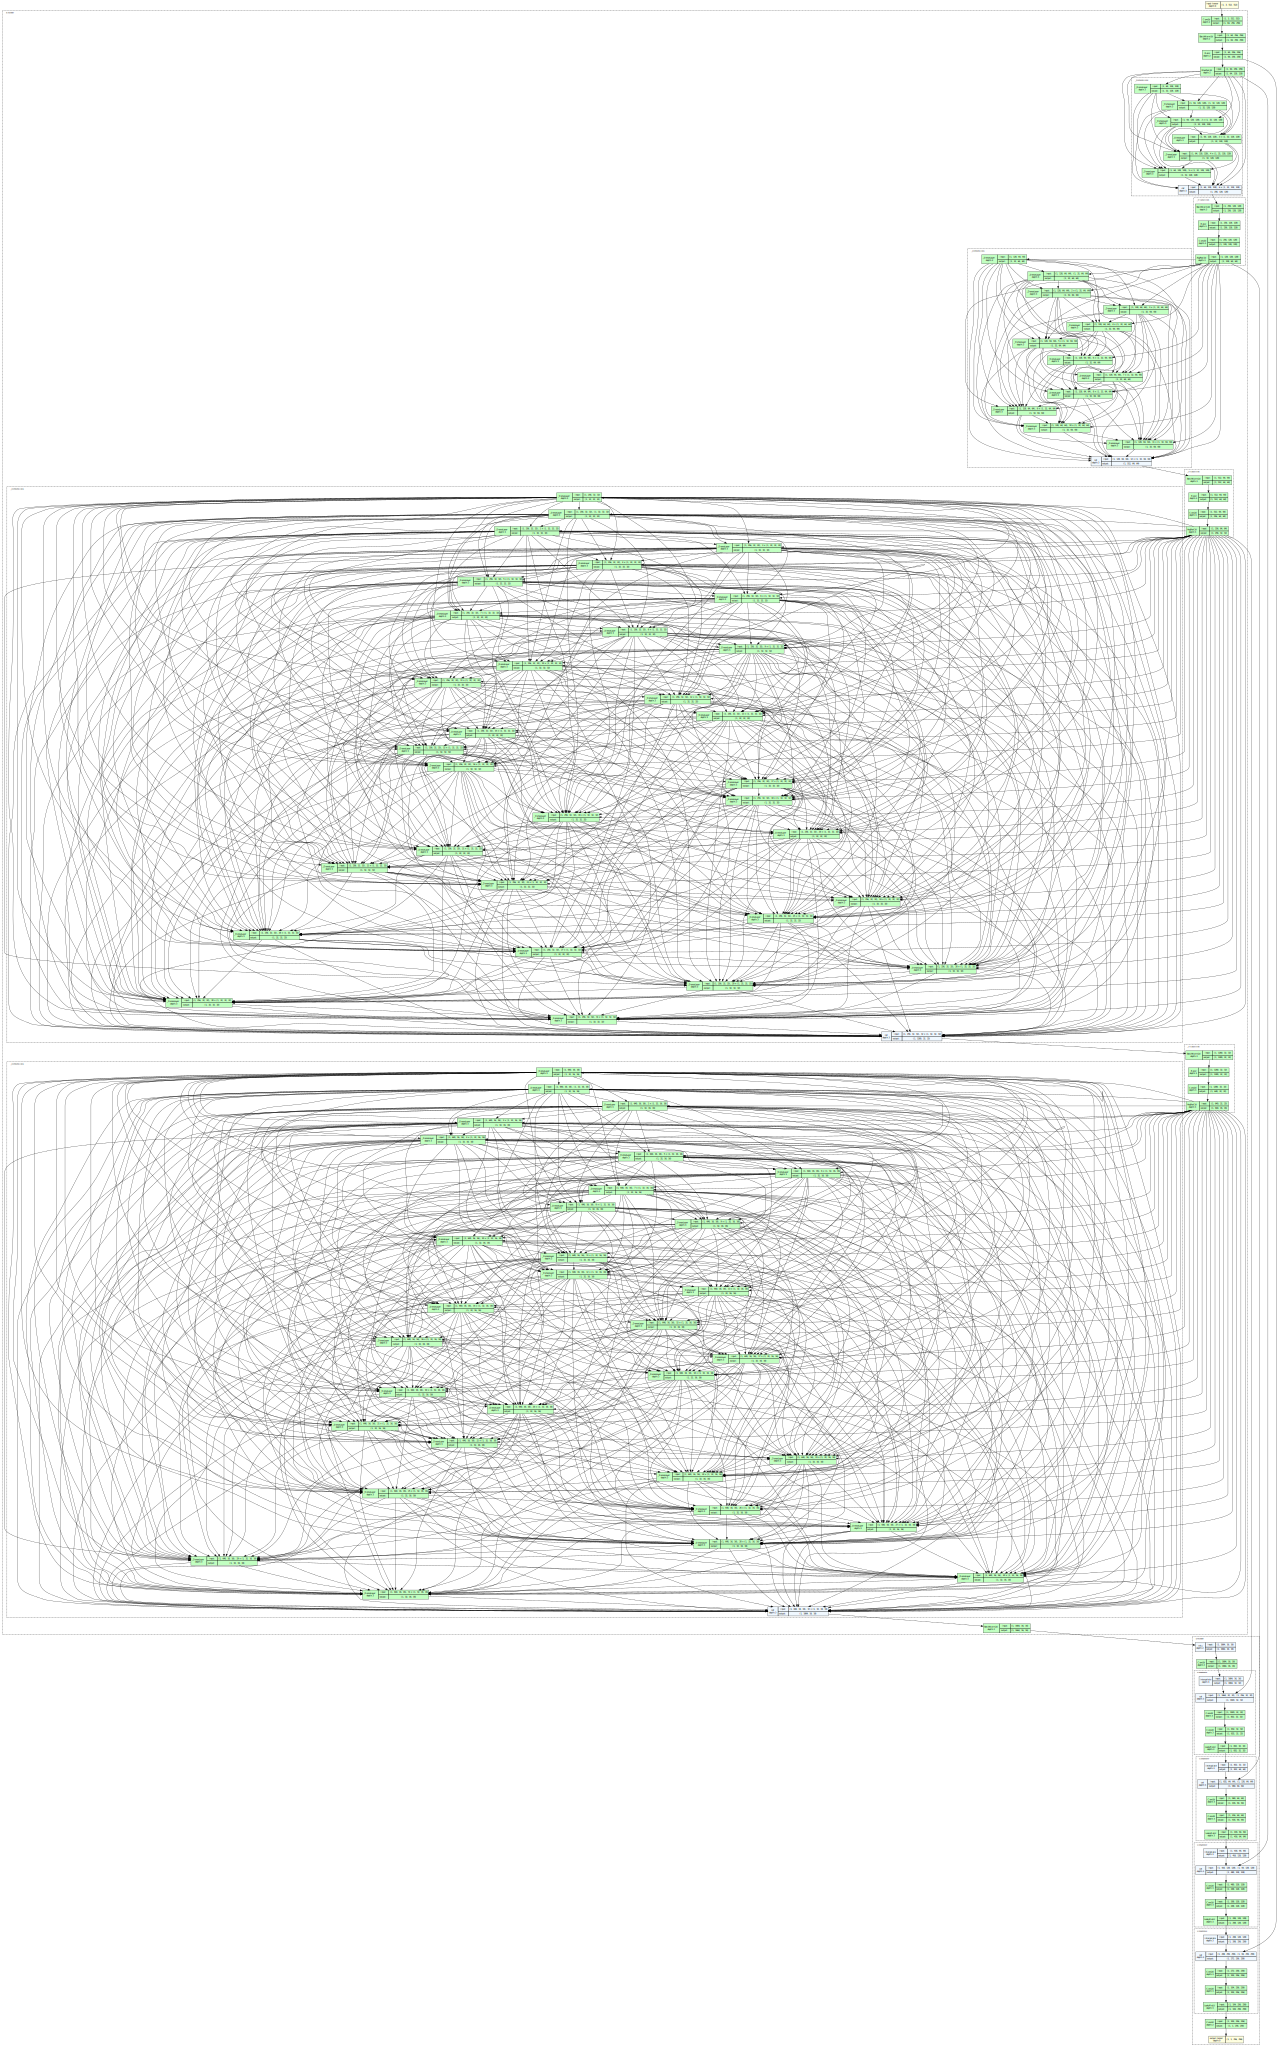

In [9]:

from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1,3,512,512), expand_nested=True)
model_graph.visual_graph